In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time    : 19-1-6 下午4:06
# @Author  : yangsen
# @Mail    : 0@keepangry.com
# @File    : baseline.py
# @Software: PyCharm
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

train = pd.read_csv('data/jinnan_round1_train_20181227.csv', encoding = 'gb18030')
test  = pd.read_csv('data/jinnan_round1_testA_20181227.csv', encoding = 'gb18030')

stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0],
                  train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))

stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values',
                                        'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]




,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,96.991404,96.991404,float64
7,A7,75,89.326648,89.326648,object
8,A8,8,89.326648,89.326648,float64
39,B11,37,60.816619,60.816619,object
38,B10,180,17.478510,17.478510,object
3,A3,3,3.008596,95.702006,float64
29,B1,21,0.716332,53.796562,float64
23,A23,3,0.214900,99.641834,float64
21,A21,12,0.214900,89.828080,float64
30,B2,3,0.143266,98.424069,float64


In [3]:
stats = []
for col in test.columns:
    stats.append((col, test[col].nunique(), test[col].isnull().sum() * 100 / test.shape[0], test[col].value_counts(normalize=True, dropna=False).values[0] * 100, test[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,98.000000,98.000000,float64
7,A7,15,88.000000,88.000000,object
8,A8,2,88.000000,88.000000,float64
39,B11,11,59.333333,59.333333,object
38,B10,50,14.666667,14.666667,object
3,A3,2,2.000000,97.333333,float64
25,A25,7,0.666667,42.000000,float64
27,A27,11,0.666667,47.333333,float64
20,A20,52,0.666667,20.000000,object
29,B1,13,0.666667,56.000000,float64


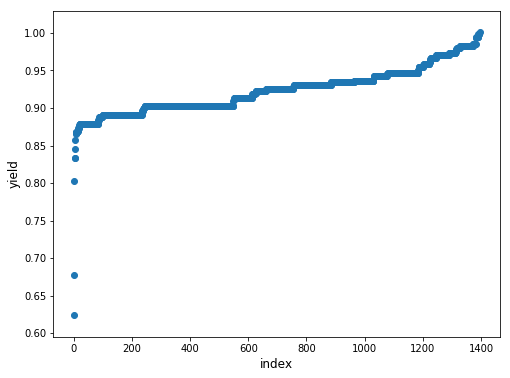

In [4]:
target_col = "收率"

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

In [5]:
# 删除类别唯一的特征
for df in [train, test]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

In [6]:
# 删除缺失率超过90%的列
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
        print(col,rate)

# 删除异常值
train = train[train['收率']>0.87]
        
train = train[good_cols]
good_cols.remove('收率')
test  = test[good_cols]

A1 0.9863896848137536
A2 0.9699140401146131
A3 0.9570200573065902
A4 0.9570200573065902
B2 0.9842406876790831


In [7]:
# 合并数据集
target = train['收率']
del train['收率']
data = pd.concat([train,test],axis=0,ignore_index=True)
data = data.fillna(-1)

In [8]:
def timeTranSecond(t):
    try:
        t,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return 7*3600/3600
        elif t=='1900/1/1 2:30':
            return (2*3600+30*60)/3600
        elif t==-1:
            return -1
        else:
            return 0
    
    try:
        tm = (int(t)*3600+int(m)*60+int(s))/3600
    except:
        return (30*60)/3600
    
    return tm
for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
    try:
        data[f] = data[f].apply(timeTranSecond)
    except:
        print(f,'应该在前面被删除了！')

def getDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1 
        
    try:
        if int(sh)>int(eh):
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600 + 24
        else:
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600
    except:
        if se=='19:-20:05':
            return 1
        elif se=='15:00-1600':
            return 1
    
    return tm
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f] = data.apply(lambda df: getDuration(df[f]), axis=1)

In [9]:
cate_columns = [f for f in data.columns if f != '样本id']

In [10]:
cate_columns

['A5',
 'A6',
 'A7',
 'A8',
 'A9',
 'A10',
 'A11',
 'A12',
 'A14',
 'A15',
 'A16',
 'A17',
 'A19',
 'A20',
 'A21',
 'A22',
 'A24',
 'A25',
 'A26',
 'A27',
 'A28',
 'B1',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B9',
 'B10',
 'B11',
 'B12',
 'B14']

In [11]:
#label encoder
for f in cate_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train.shape[0]]
test  = data[train.shape[0]:]

In [12]:
train['target'] = target
train['intTarget'] = pd.cut(train['target'], 5, labels=False)
train = pd.get_dummies(train, columns=['intTarget'])
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']
mean_features = []

for f1 in cate_columns:
    rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
    if rate < 0.50:
        for f2 in li:
            col_name = f1+"_"+f2+'_mean'
            mean_features.append(col_name)
            order_label = train.groupby([f1])[f2].mean()
            for df in [train, test]:
                df[col_name] = df[f].map(order_label)

train.drop(li, axis=1, inplace=True)

In [13]:
train.drop(['样本id','target'], axis=1, inplace=True)
test = test[train.columns]
X_train = train.values
y_train = target.values
X_test = test.values
print(X_train.shape)
print(X_test.shape)

(1381, 112)
(150, 112)


In [14]:
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, target)))

fold n°1
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.00021343	valid_1's l2: 0.000238687
[400]	training's l2: 0.000165706	valid_1's l2: 0.000193927
[600]	training's l2: 0.000148964	valid_1's l2: 0.000186157
[800]	training's l2: 0.000140166	valid_1's l2: 0.000183198
[1000]	training's l2: 0.000134396	valid_1's l2: 0.00018171
[1200]	training's l2: 0.000130255	valid_1's l2: 0.00018054
[1400]	training's l2: 0.000127068	valid_1's l2: 0.000180082
[1600]	training's l2: 0.000124491	valid_1's l2: 0.000179665
[1800]	training's l2: 0.000122279	valid_1's l2: 0.000179374
[2000]	training's l2: 0.000120381	valid_1's l2: 0.000179072
Early stopping, best iteration is:
[2064]	training's l2: 0.00011985	valid_1's l2: 0.00017895
fold n°2
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000213571	valid_1's l2: 0.000235153
[400]	training's l2: 0.000163691	valid_1's l2: 0.000207972
[600]	training's l2: 0.000147031	valid_1's l2: 0.000

In [ ]:
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, target)))

fold n°1
[0]	train-rmse:0.422932	valid_data-rmse:0.423819
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.257003	valid_data-rmse:0.257732
[200]	train-rmse:0.156586	valid_data-rmse:0.157239
[300]	train-rmse:0.095958	valid_data-rmse:0.096493
[400]	train-rmse:0.059503	valid_data-rmse:0.060005
[500]	train-rmse:0.03776	valid_data-rmse:0.038465
[600]	train-rmse:0.024961	valid_data-rmse:0.0261
[700]	train-rmse:0.017549	valid_data-rmse:0.019365
[800]	train-rmse:0.013328	valid_data-rmse:0.015908
[900]	train-rmse:0.010956	valid_data-rmse:0.014251
[1000]	train-rmse:0.009594	valid_data-rmse:0.013492
[1100]	train-rmse:0.008768	valid_data-rmse:0.013139
[1200]	train-rmse:0.008216	valid_data-rmse:0.01297
[1300]	train-rmse:0.007827	valid_data-rmse:0.012873
[1400]	train-rmse:0.007529	valid_data-rmse:0.012844
[1500]	train-rmse:0.00729	valid_data-rmse:0.012849
[1600]	train-rmse:0.

In [ ]:
X_test